In [1]:
## imports
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.io import read_file, decode_image
import keras
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Activation, Conv2D, MaxPooling2D, MaxPool2D, Flatten, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.utils import plot_model
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split, KFold
import matplotlib.pyplot as plt
import random
import librosa
import librosa.display

In [2]:
## from https://www.tensorflow.org/guide/gpu for limiting gpu growth
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
    # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [ ]:
## read .wav files and convert to mel spectrograms

dataset = []
genres = {'blues': 0, 'classical': 1, 'country': 2, 'disco': 3, 'hiphop': 4, 
        'jazz': 5, 'metal': 6, 'pop': 7, 'reggae': 8, 'rock': 9}
image_genres = {'blues', 'classical','country','disco'}
images_dir = os.path.join(os.getcwd(),'Data','genres_original')

for genre, genre_number in genres.items():
    for filename in os.listdir(os.path.join(images_dir,genre)):
        songname = os.path.join(images_dir, genre, filename)
        for index in range(14):
            y, sr = librosa.load(songname, mono=True, duration=2, offset=index*2)
            ps = librosa.feature.melspectrogram(y=y, sr=sr, hop_length=256, n_fft=512, n_mels=64)
            ps = librosa.power_to_db(ps**2)
            dataset.append((ps, genre_number))

In [ ]:
## save dataset so previous cell doesn't have to be run after restarting kernel
np.save('dataset_cnn.npy',dataset)

In [3]:
## run this cell to load saved dataset
genres = {'blues': 0, 'classical': 1, 'country': 2, 'disco': 3, 'hiphop': 4, 
        'jazz': 5, 'metal': 6, 'pop': 7, 'reggae': 8, 'rock': 9}
class_num = len(genres)
dataset = np.load('dataset_cnn.npy',allow_pickle=True)

In [4]:
## shuffle and split dataset into training, testing, and validation

random.shuffle(dataset)

train = dataset[:10000]
valid = dataset[10000:12000]
test = dataset[12000:]

print('Training size:',len(train)/len(dataset))
print('Testing size:',len(test)/len(dataset))
print('Validation size:',len(valid)/len(dataset))

X_train, Y_train = zip(*train)
X_valid, Y_valid = zip(*valid)
X_test, Y_test = zip(*test)

# Reshape for CNN input
X_train = np.array([x.reshape( (64, 173, 1) ) for x in X_train])
X_valid = np.array([x.reshape( (64, 173, 1) ) for x in X_valid])
X_test = np.array([x.reshape( (64, 173, 1) ) for x in X_test])

# One-Hot encoding for classes
Y_train = np.array(keras.utils.to_categorical(Y_train, class_num))
Y_valid = np.array(keras.utils.to_categorical(Y_valid, class_num))
Y_test = np.array(keras.utils.to_categorical(Y_test, class_num))

input_shape = X_train[0].shape

Training size: 0.715000715000715
Testing size: 0.141999141999142
Validation size: 0.143000143000143


In [10]:
## cnn model, based on vgg-19
def define_cnn(input_shape, class_num):

    model = Sequential([
      
        Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu', input_shape=input_shape),
        MaxPool2D(pool_size=(2,2)),
    
        Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'),
        MaxPool2D(pool_size=(2,2)),
    
        Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'),
        Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'),
        MaxPool2D(pool_size=(2,2)),
        Dropout(0.2),
        
        Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'),
        Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'),
        MaxPool2D(pool_size=(2,2)),
        Dropout(0.2),
        
        Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'),
        Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'),
        MaxPool2D(pool_size=(2,2)),
        Dropout(0.2),
    
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.25),
        Dense(256, activation='relu'),
        Dropout(0.25),
        Dense(class_num, activation='softmax')

    ])
    optimizer = Adam()
    model.compile(
      
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']

    )
    return model

In [7]:
## used to check gpu usage
tf.config.experimental.get_memory_info('GPU:0')['current'] / 10**9

0.0

In [5]:
## function for model fitting
def train_model(model, X, y, X_vd, y_vd):
    history = model.fit(
        X,
        y,
        epochs=20,
        batch_size=64,
        validation_data=(X_vd,y_vd)
    )
    return model, history

In [8]:
## function for model evaluation
def model_prediction(model, X_data, y_true):
    y_pred = model.predict(X_data)
    y_pred = y_pred.argmax(axis=1)
    y_true = y_true.argmax(axis=1) # use this line if label is one-hot using categorical crossentropy
    accuracy = accuracy_score(y_true, y_pred)
    print(classification_report(y_true, y_pred, target_names=genres))
    print('Overall Accuracy:', accuracy)
    
    return y_pred, accuracy

In [11]:
cnn_model = define_cnn(input_shape, class_num)

In [ ]:
## model summary and diagram
cnn_model.summary()
plot_model(cnn_model, to_file='cnn_model_plot.png', show_shapes=True,show_layer_names=False)

In [12]:

cnn_model_trained, history = train_model(cnn_model, X_train, Y_train, X_valid, Y_valid)

Epoch 1/20
157/157 [==============================] - 27s 108ms/step - loss: 2.3062 - accuracy: 0.1445 - val_loss: 2.0263 - val_accuracy: 0.2205
Epoch 2/20
157/157 [==============================] - 15s 95ms/step - loss: 1.8625 - accuracy: 0.2838 - val_loss: 1.6243 - val_accuracy: 0.3570
Epoch 3/20
157/157 [==============================] - 15s 95ms/step - loss: 1.5411 - accuracy: 0.4190 - val_loss: 1.3911 - val_accuracy: 0.4850
Epoch 4/20
157/157 [==============================] - 15s 95ms/step - loss: 1.3167 - accuracy: 0.5097 - val_loss: 1.4491 - val_accuracy: 0.4975
Epoch 5/20
157/157 [==============================] - 15s 95ms/step - loss: 1.1172 - accuracy: 0.6057 - val_loss: 1.2757 - val_accuracy: 0.5810
Epoch 6/20
157/157 [==============================] - 15s 96ms/step - loss: 0.9488 - accuracy: 0.6793 - val_loss: 1.0045 - val_accuracy: 0.6840
Epoch 7/20
157/157 [==============================] - 15s 95ms/step - loss: 0.7670 - accuracy: 0.7476 - val_loss: 0.9062 - val_accuracy

Text(0.5, 1.0, 'Accuracy')

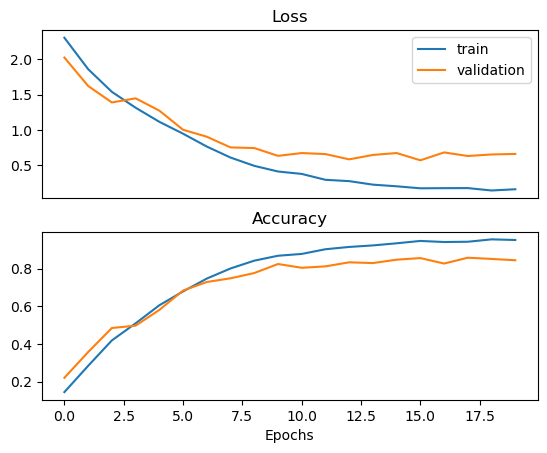

In [13]:
plt.subplot(2,1,1)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.title('Loss')
plt.xticks([], [])
plt.legend()
plt.subplot(2,1,2)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.xlabel('Epochs')
plt.title('Accuracy')

In [14]:
y_im_pred, acc_cnn2d = model_prediction(cnn_model_trained, X_test, Y_test)
_,_ = model_prediction(cnn_model_trained, X_train, Y_train)

63/63 [==============================] - 3s 19ms/step
              precision    recall  f1-score   support

       blues       0.96      0.61      0.75       196
   classical       0.93      0.97      0.95       212
     country       0.78      0.83      0.80       208
       disco       0.87      0.91      0.89       208
      hiphop       0.94      0.75      0.83       182
        jazz       0.77      0.92      0.84       200
       metal       0.94      0.90      0.92       193
         pop       0.85      0.84      0.85       211
      reggae       0.76      0.91      0.83       194
        rock       0.67      0.69      0.68       182

    accuracy                           0.84      1986
   macro avg       0.85      0.83      0.83      1986
weighted avg       0.85      0.84      0.84      1986

Overall Accuracy: 0.8373615307150051
313/313 [==============================] - 4s 13ms/step
              precision    recall  f1-score   support

       blues       1.00      0.89      

Results of test set after training on training and validation sets

              precision    recall  f1-score   support

       blues       0.83      0.87      0.85       202
   classical       0.94      0.95      0.95       202
     country       0.76      0.80      0.78       189
       disco       0.91      0.87      0.89       190
      hiphop       0.88      0.90      0.89       218
        jazz       0.87      0.84      0.86       194
       metal       0.94      0.91      0.92       189
         pop       0.85      0.82      0.84       203
      reggae       0.90      0.82      0.86       216
        rock       0.72      0.79      0.75       183

    accuracy                           0.86      1986
   macro avg       0.86      0.86      0.86      1986
weighted avg       0.86      0.86      0.86      1986

Overall Accuracy: 0.8590130916414904

In [ ]:
np.mean([0.9245889921372409, 0.9063282087951376, 0.9295673936360386, 0.882016446192349, 0.9156540385989993])

In [16]:
X, Y = zip(*dataset)

X = np.array([x.reshape( (64, 173, 1) ) for x in X])
Y = np.array(keras.utils.to_categorical(Y, class_num))


n_folds = 5
kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
accuracy_scores = []
i = 0
for train_index, test_index in kf.split(X):
    
    X_train = X[train_index]
    X_test = X[test_index]
    Y_train = Y[train_index]
    Y_test = Y[test_index]
    input_shape = X_train[0].shape
    cnn_model = define_cnn(input_shape, class_num)
    trained_model, history = train_model(cnn_model, 
                                         X_train, Y_train,
                                         X_test, Y_test)
    
    accuracy = model_prediction(trained_model, X_test, Y_test)
    accuracy_scores.append(accuracy)
        
mean_accuracy = np.mean(accuracy_scores)
print("Mean Accuracy: {:.2f}%".format(mean_accuracy * 100))
print("Accuracy Scores for Each Fold: ", accuracy_scores) 

0.7999427999427999
0.8000143000143
0.8000143000143
0.8000143000143
0.8000143000143
Mean Accuracy: nan%
Accuracy Scores for Each Fold:  []


C:\Users\slack\anaconda3\envs\infoh518\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\slack\anaconda3\envs\infoh518\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [15]:
X, Y = zip(*dataset)

X = np.array([x.reshape( (64, 173, 1) ) for x in X])
Y = np.array(keras.utils.to_categorical(Y, class_num))


0.20005720005720007

k-fold cross validation results

Fold 1:
              precision    recall  f1-score   support

       blues       0.91      0.91      0.91       279
   classical       0.96      0.97      0.97       294
     country       0.84      0.94      0.89       295
       disco       0.82      0.96      0.89       280
      hiphop       0.97      0.92      0.94       281
        jazz       0.97      0.85      0.90       264
       metal       0.98      0.92      0.95       308
         pop       0.91      0.94      0.93       244
      reggae       0.96      0.92      0.94       281
        rock       0.87      0.80      0.84       272

    accuracy                           0.92      2798
   macro avg       0.92      0.91      0.92      2798
weighted avg       0.92      0.92      0.92      2798

Overall Accuracy: 0.9156540385989993

Fold 2:
              precision    recall  f1-score   support

       blues       0.83      0.87      0.85       287
   classical       0.87      0.98      0.92       264
     country       0.75      0.92      0.83       281
       disco       0.93      0.89      0.91       266
      hiphop       0.94      0.86      0.90       263
        jazz       0.97      0.76      0.85       288
       metal       0.90      0.96      0.93       287
         pop       0.90      0.96      0.93       290
      reggae       0.98      0.81      0.89       302
        rock       0.82      0.81      0.82       269

    accuracy                           0.88      2797
   macro avg       0.89      0.88      0.88      2797
weighted avg       0.89      0.88      0.88      2797

Overall Accuracy: 0.882016446192349

Fold 3:
              precision    recall  f1-score   support

       blues       0.89      0.97      0.93       291
   classical       0.93      0.98      0.95       304
     country       0.97      0.86      0.91       298
       disco       0.95      0.93      0.94       264
      hiphop       0.91      0.98      0.94       283
        jazz       0.93      0.92      0.93       250
       metal       0.94      0.98      0.96       297
         pop       0.94      0.89      0.92       238
      reggae       0.98      0.91      0.94       291
        rock       0.88      0.86      0.87       281

    accuracy                           0.93      2797
   macro avg       0.93      0.93      0.93      2797
weighted avg       0.93      0.93      0.93      2797

Overall Accuracy: 0.9295673936360386

Fold 4:
              precision    recall  f1-score   support

       blues       0.93      0.91      0.92       291
   classical       0.97      0.98      0.98       291
     country       0.94      0.81      0.87       299
       disco       0.82      0.95      0.88       246
      hiphop       0.95      0.93      0.94       284
        jazz       0.90      0.95      0.92       273
       metal       0.96      0.91      0.93       297
         pop       0.89      0.89      0.89       263
      reggae       0.97      0.87      0.92       271
        rock       0.76      0.87      0.81       282

    accuracy                           0.91      2797
   macro avg       0.91      0.91      0.91      2797
weighted avg       0.91      0.91      0.91      2797

Overall Accuracy: 0.9063282087951376

Fold 5:
              precision    recall  f1-score   support

       blues       0.94      0.90      0.92       279
   classical       0.93      1.00      0.96       294
     country       0.85      0.92      0.88       295
       disco       0.93      0.93      0.93       280
      hiphop       0.97      0.94      0.95       281
        jazz       0.94      0.89      0.92       264
       metal       0.94      0.96      0.95       308
         pop       0.90      0.97      0.93       244
      reggae       0.94      0.93      0.93       281
        rock       0.91      0.81      0.86       272

    accuracy                           0.92      2798
   macro avg       0.93      0.92      0.92      2798
weighted avg       0.93      0.92      0.92      2798

Overall Accuracy: 0.9245889921372409

Mean accuracy: 91.16%

## 